In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import string
import random
import string
from sklearn import linear_model
from scipy.spatial import distance
from fastFM import als
from sklearn.metrics import r2_score
from textblob import TextBlob
from sklearn.model_selection import KFold 
from sklearn.metrics import mean_squared_error 
from itertools import product 

In [2]:
# load in the raw data for recipes and ratings
raw_recipes = pd.read_csv(os.path.join('archive', 'RAW_recipes.csv'))
raw_interactions = pd.read_csv(os.path.join('archive', 'RAW_interactions.csv'))

In [3]:
raw_interactions.shape[0]

1132367

In [4]:
raw_interactions

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...


In [5]:
raw_interactions.dtypes

user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

In [6]:
raw_interactions['date'] = pd.to_datetime(raw_interactions['date'])


In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords from NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/yuz159/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/yuz159/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to tokenize and remove stopwords
def clean_text(review):
    # Check if the review is a string
    if isinstance(review, str):
        tokens = word_tokenize(review)
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        return " ".join(filtered_tokens)
    else:
        # Return empty string for non-string or missing values
        return ""

# Apply the function to the review column
raw_interactions['cleaned_review'] = raw_interactions['review'].apply(clean_text)


In [11]:
raw_interactions

,user_id,recipe_id,date,rating,review,cleaned_review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,Great salad . Cooked top stove 15 minutes.Adde...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...","simple , delicious ! Great chilly fall evening..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,worked well EASY . used quite whole package ( ...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,made Mexican topping took bunko . Everyone lov...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...","Made cheddar bacon topping , adding sprinkling..."
...,...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,Another approach start making sauce fresh cran...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,delicious ! husband truly enjoyed burgers . te...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,WOW ! Sometimes n't take time rate recipes one...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,good ! used regular port well . gravy nicely f...


In [12]:
#Import lib
# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(style="white", font_scale = 1.3)

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

%config InlineBackend.figure_formats = ['svg']
plt.rcParams["figure.figsize"] = [12, 6]

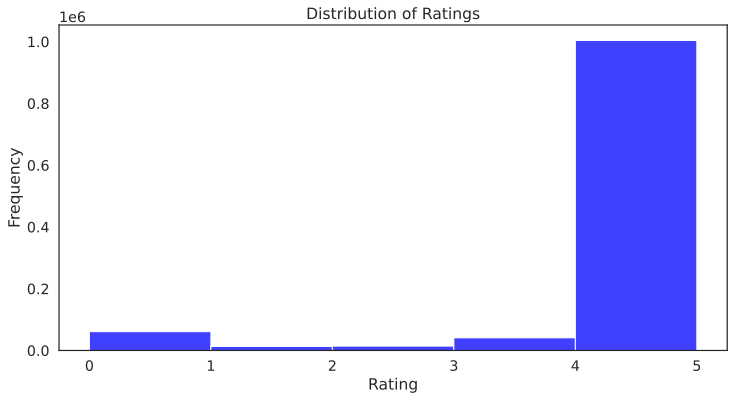

In [13]:
# Create the distribution plot
sns.histplot(raw_interactions['rating'], kde=False, bins=5, color='blue')

# Set the title and labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Save the plot before showing it
plt.savefig('distribution_of_ratings.png')

# Show the plot
plt.show()


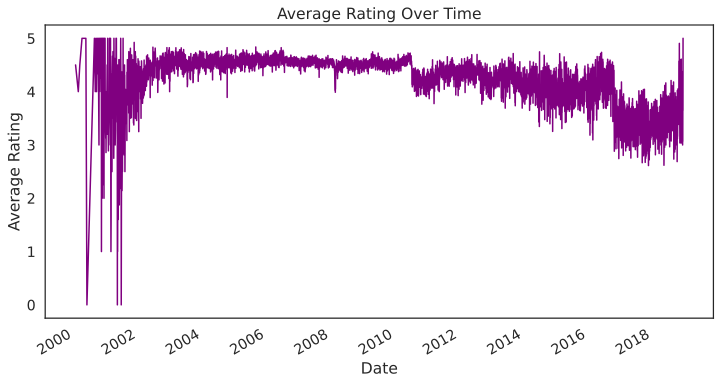

In [14]:
# Assuming your DataFrame is named raw_interactions
# Group the data by date and calculate the average rating for each date
average_ratings_per_day = raw_interactions.groupby('date')['rating'].mean()

# Plotting the time series of average ratings
average_ratings_per_day.plot(kind='line', color='purple')

# Set the title and labels
plt.title('Average Rating Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.savefig('rating_data_relation.png')
# Show the plot
plt.show()


In [19]:
# pip install textblob

In [20]:
raw_interactions

,user_id,recipe_id,date,rating,review,cleaned_review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,Great salad . Cooked top stove 15 minutes.Adde...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...","simple , delicious ! Great chilly fall evening..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,worked well EASY . used quite whole package ( ...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,made Mexican topping took bunko . Everyone lov...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...","Made cheddar bacon topping , adding sprinkling..."
...,...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,Another approach is to start making sauce with...,Another approach start making sauce fresh cran...
1132363,583662,386618,2009-09-29,5,These were so delicious! My husband and I tru...,delicious ! husband truly enjoyed burgers . te...
1132364,157126,78003,2008-06-23,5,WOW! Sometimes I don't take the time to rate ...,WOW ! Sometimes n't take time rate recipes one...
1132365,53932,78003,2009-01-11,4,Very good! I used regular port as well. The ...,good ! used regular port well . gravy nicely f...


In [21]:
# Function to calculate sentiment
def calculate_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply the function to create a new column for sentiment
raw_interactions['sentiment'] = raw_interactions['cleaned_review'].apply(calculate_sentiment)




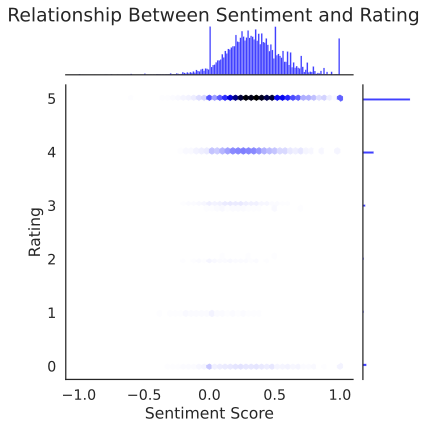

In [22]:
# Downsample the data to 10% of its original size
downsampled_interactions = raw_interactions.sample(frac=0.1, random_state=1)

sns.jointplot(x='sentiment', y='rating', kind="hex", data=downsampled_interactions, color="blue")

plt.suptitle('Relationship Between Sentiment and Rating',y=1) # Adjust title position
plt.xlabel('Sentiment Score')
plt.ylabel('Rating')
plt.savefig('sentiment_rating.png')
plt.show()


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [50]:
# Assuming df is your DataFrame
X = raw_interactions.drop('rating', axis=1)  # Features matrix
y = raw_interactions['rating']  # Target variable

# Preprocess the 'date' column (example: converting to days since the first review)
X['date'] = pd.to_datetime(X['date'])
X['days_since'] = (X['date'] - X['date'].min()).dt.days
X.drop('date', axis=1, inplace=True)

# Define a transformer for categorical columns (OneHotEncoder)
categorical_features = ['user_id', 'recipe_id']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Define a transformer for text columns (TF-IDF Vectorizer)
text_features = 'cleaned_review'
text_transformer = TfidfVectorizer()

# Combine transformers into a preprocessor step
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('text', text_transformer, text_features)
    ])

# Create a pipeline that preprocesses and then applies a model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LinearRegression())])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R-squared: {r2}')


MSE: 1.795112233812158
R-squared: -0.10905033403935116


In [23]:
nUsers = raw_interactions["user_id"].nunique()

In [24]:
nItems = raw_interactions["recipe_id"].nunique()

In [25]:
nItems

231637

In [26]:
allRecipe = [tuple(r) for r in raw_interactions[['user_id', 'recipe_id', 'rating']].to_numpy()]

In [27]:
userIDs,itemIDs = {},{}

In [28]:
for t in allRecipe:
    u,i = t[0],t[1]
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

In [29]:
userIDs

{38094: 0,
 1293707: 1,
 8937: 2,
 126440: 3,
 57222: 4,
 52282: 5,
 124416: 6,
 2000192946: 7,
 76535: 8,
 273745: 9,
 353911: 10,
 190375: 11,
 468945: 12,
 255338: 13,
 1171894: 14,
 136726: 15,
 68960: 16,
 618928: 17,
 217118: 18,
 2000049093: 19,
 202555: 20,
 353579: 21,
 635209: 22,
 681408: 23,
 684460: 24,
 900992: 25,
 135017: 26,
 224088: 27,
 582223: 28,
 1413963: 29,
 483827: 30,
 56680: 31,
 5060: 32,
 935485: 33,
 539686: 34,
 6258: 35,
 102602: 36,
 172467: 37,
 2042100: 38,
 2002068522: 39,
 58332: 40,
 160497: 41,
 67026: 42,
 183565: 43,
 101823: 44,
 349752: 45,
 446143: 46,
 226989: 47,
 868654: 48,
 1143059: 49,
 302867: 50,
 1316788: 51,
 1447190: 52,
 1003295: 53,
 930021: 54,
 241697: 55,
 980899: 56,
 158966: 57,
 827374: 58,
 1719774: 59,
 49304: 60,
 152118: 61,
 1781977: 62,
 1874846: 63,
 1631574: 64,
 1802624639: 65,
 1802697284: 66,
 2002097693: 67,
 337963: 68,
 226081: 69,
 185285: 70,
 180087: 71,
 240552: 72,
 805572: 73,
 1802811100: 74,
 263525: 7

In [30]:
nUsers,nItems = len(userIDs),len(itemIDs)

In [31]:
nUsers,nItems

(226570, 231637)

In [32]:
X = scipy.sparse.lil_matrix((len(allRecipe), nUsers + nItems))

In [33]:
allRecipe[0]

(38094, 40893, 4)

In [34]:
for i in range(len(allRecipe)):
    user = userIDs[allRecipe[i][0]]
    item = itemIDs[allRecipe[i][1]]
    X[i,user] = 1 # One-hot encoding of user
    X[i,nUsers + item] = 1 # One-hot encoding of item

In [35]:
y = np.array([d[2] for d in allRecipe])

In [36]:
X.shape

(1132367, 458207)

In [37]:
y.shape

(1132367,)

In [38]:
1132367//2

566183

In [39]:
(1132367 - 566183) // 5

113236

In [40]:
113236 * 3

339708

In [41]:
1132367 - 566183 - 339708

226476

In [42]:
566183 + 339708

905891

In [43]:
X_train,y_train = X[:566183],y[:566183]
X_valid,y_valid = X[566183:905891],y[566183:905891]
X_test,y_test = X[905891:],y[905891:]

In [44]:
fm = als.FMRegression(n_iter=100, init_stdev=0.5, rank=2, l2_reg_w=3, l2_reg_V=20)
fm.fit(X_train, y_train)

FMRegression(init_stdev=0.5, l2_reg_V=20, l2_reg_w=3, rank=2)

In [45]:
y_pred = fm.predict(X_valid)

In [46]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [47]:
MSE(y_pred,y_valid)

1.487800532603434

In [48]:
r2_score(y_valid, y_pred)

0.08304537992892902

In [ ]:
kf = KFold(n_splits=5)
parameter_grid = {
    'n_iter': [500],
    'init_stdev': [0.01, 0.03],
    'rank': [2, 5],
    'l2_reg_w': [0.1, 1, 2],
    'l2_reg_V': [10, 30, 60]
}

In [ ]:
best_mse = float('inf')
best_params = None
# Iterate over all combinations of parameters
for params in product(*parameter_grid.values()): 
    param_dict = dict(zip(parameter_grid.keys(), params)) 
    mse_list = []
    # K-Fold Cross Validation
    for train_index, val_index in kf.split(X): 
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        fm = als.FMRegression(**param_dict)
        fm.fit(X_train, y_train)
        y_pred = fm.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        mse_list.append(mse)
    # Calculate average MSE over all folds
    avg_mse = np.mean(mse_list)
    
    # Update best parameters if necessary
    if avg_mse < best_mse: 
        best_mse = avg_mse 
        best_params = param_dict
        
print("Best Parameters:", best_params)
print("Best MSE:", best_mse)